# Predict ice hockey game result with machine learning

The use of data analytics and statistics to predict outcome of sport events is nothing new and is of course used by the betting companies. You look at trends, table position, head-to-head results etc. And for the individual players, dont forget the most important aspect: This vague "feeling".  

My "feeling" is normally not very accurate, and thus I wanted to set up a machine learning model that predicted the outcome of ice hockey games. Maybe this could help me to improve accuracy in my predictions, and not loose that much money. 

This notebook describes how I developed a random forest classifier to predict outcome of ice hockey games in the swedish 1st and 2nd league. I will also apply the model to the season results to see how it would have performed.

I will use two datasets collected with the package ```swehockey_scraper``` which collects data from www.stats.swehockey.se. 
Details about the package is found here [github project for ice-hockey-analysis](https://github.com/msjoelin/swehockey_scraper)

Steps:
1. Import data
2. Exploratory analysis
3. Prepare data for modeling
4. Train model
5. Evaluate performance
6. Apply model to result current season and 

So let's start!

### 1) Import  packages and data


In [1]:
import numpy as np
import pandas as pd

# sklearn will be used to build the model
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# To save the model
import pickle

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


In [46]:
# Import data from csv file, keep relevant columns
df_games = pd.read_csv("C:/Users/marcu/Documents/projects/icehockey/data/df_games.csv")
df_teams = pd.read_csv("C:/Users/marcu/Documents/projects/icehockey/data/df_teams.csv")

print(df_games.shape[0], " matches imported")
print(df_teams.shape[0], " teamrows imported")

9184  matches imported
18368  teamrows imported


In [47]:
# Select only relevant columns for the analy
df_games = df_games[['date', 'game', 'score', 'league', 'season', 'game_id', 
                'home', 'away', 'score_home', 'score_away', 'result']]

df_matches.head()

,date,game,score,league,season,game_id,home,away,score_home,score_away,result
0,2019-09-14,Frölunda HC - Brynäs IF,2 - 5,shl,2019/20,441805,Frölunda HC,Brynäs IF,2,5,away
1,2019-09-14,Skellefteå AIK - IK Oskarshamn,5 - 4,shl,2019/20,441808,Skellefteå AIK,IK Oskarshamn,5,4,draw
2,2019-09-14,Leksands IF - IF Malmö Redhawks,5 - 2,shl,2019/20,441809,Leksands IF,IF Malmö Redhawks,5,2,home
3,2019-09-14,Djurgårdens IF - Linköping HC,4 - 2,shl,2019/20,441803,Djurgårdens IF,Linköping HC,4,2,home
4,2019-09-14,Färjestad BK - Örebro HK,4 - 6,shl,2019/20,441804,Färjestad BK,Örebro HK,4,6,away


In [49]:
df_teams = df_teams[['game_id', 'team', 'h_a', 
                     'win_R5', 'draw_R5', 'lost_R5',  
                     'H2H_W', 'H2H_D', 'H2H_L',
                    'scored_avg_R5', 'conceded_avg_R5',
                    'points_cum_prev_avg', 'points_cum_h_a_prev_avg']]
df_teams.head()

,game_id,team,h_a,win_R5,draw_R5,lost_R5,H2H_W,H2H_D,H2H_L,scored_avg_R5,conceded_avg_R5,points_cum_prev_avg,points_cum_h_a_prev_avg
0,422474,AIK,away,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,NaN,NaN
1,422481,AIK,home,0.000000,0.000000,1.000000,0.0,0.0,0.0,3.0,7.000000,0.000000,NaN
2,422484,AIK,away,0.500000,0.000000,0.500000,0.0,0.0,0.0,4.5,5.500000,1.500000,0.0
3,422494,AIK,home,0.333333,0.333333,0.333333,0.0,0.0,0.0,4.0,4.333333,1.666667,3.0
4,422499,AIK,away,0.500000,0.250000,0.250000,0.0,0.0,0.0,4.5,3.750000,2.000000,1.0


In [50]:
# Split into home and away data
df_home = df_teams[df_teams['h_a']=='home'].copy().drop(['team', 'h_a'], axis=1).add_suffix('_home').rename(columns={"game_id_home": "game_id"})
df_away = df_teams[df_teams['h_a']=='away'].copy().drop(['team', 'h_a'], axis=1).add_suffix('_away').rename(columns={"game_id_away": "game_id"})

In [51]:
df_games_trend = pd.merge(df_games, df_home, 
                   on='game_id', how='left')

df_games_trend = pd.merge(df_games_trend, df_away, 
                   on='game_id', how='left')

#df_games_trend.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9184 entries, 0 to 9183
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   date                          9184 non-null   object 
 1   game                          9184 non-null   object 
 2   score                         9184 non-null   object 
 3   league                        9184 non-null   object 
 4   season                        9184 non-null   object 
 5   game_id                       9184 non-null   int64  
 6   home                          9184 non-null   object 
 7   away                          9184 non-null   object 
 8   score_home                    9184 non-null   int64  
 9   score_away                    9184 non-null   int64  
 10  result                        9184 non-null   object 
 11  win_R5_home                   9184 non-null   float64
 12  draw_R5_home                  9184 non-null   float64
 13  los

In [53]:
df_games_trend=df_games_trend.drop(['H2H_W_away', 'H2H_D_away', 'H2H_L_away'], axis=1)

df_games_trend=df_games_trend.rename(columns={"H2H_W_home": "H2H_W", "H2H_D_home": "H2H_D", "H2H_L_home": "H2H_L"})

df_games_trend.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9184 entries, 0 to 9183
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   date                          9184 non-null   object 
 1   game                          9184 non-null   object 
 2   score                         9184 non-null   object 
 3   league                        9184 non-null   object 
 4   season                        9184 non-null   object 
 5   game_id                       9184 non-null   int64  
 6   home                          9184 non-null   object 
 7   away                          9184 non-null   object 
 8   score_home                    9184 non-null   int64  
 9   score_away                    9184 non-null   int64  
 10  result                        9184 non-null   object 
 11  win_R5_home                   9184 non-null   float64
 12  draw_R5_home                  9184 non-null   float64
 13  los

### 2) Exploratory analysis

As always the first step is to explore the data. 

In [54]:
df_games_trend.head()

,date,game,score,league,season,game_id,home,away,score_home,score_away,...,conceded_avg_R5_home,points_cum_prev_avg_home,points_cum_h_a_prev_avg_home,win_R5_away,draw_R5_away,lost_R5_away,scored_avg_R5_away,conceded_avg_R5_away,points_cum_prev_avg_away,points_cum_h_a_prev_avg_away
0,2019-09-14,Frölunda HC - Brynäs IF,2 - 5,shl,2019/20,441805,Frölunda HC,Brynäs IF,2,5,...,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN
1,2019-09-14,Skellefteå AIK - IK Oskarshamn,5 - 4,shl,2019/20,441808,Skellefteå AIK,IK Oskarshamn,5,4,...,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,2019-09-14,Leksands IF - IF Malmö Redhawks,5 - 2,shl,2019/20,441809,Leksands IF,IF Malmö Redhawks,5,2,...,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,2019-09-14,Djurgårdens IF - Linköping HC,4 - 2,shl,2019/20,441803,Djurgårdens IF,Linköping HC,4,2,...,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,2019-09-14,Färjestad BK - Örebro HK,4 - 6,shl,2019/20,441804,Färjestad BK,Örebro HK,4,6,...,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN


The dataset contains one row for every game, and with many columns - most of them probably not very relevant for the analysis. 

The column names contain suffix "home" and "away", belonging to the specific teams. 
Example:
draw_R5_away:  Number of draw results the away team had the previous 5 games 

Check out the definitions in the github-project for description of all columns. 
To validate what data is available, lets group by season and league. 

In [55]:
print(df_games_trend['season'].value_counts())
print(df_games_trend['league'].value_counts())

2018/19    728
2015/16    728
2017/18    728
2016/17    728
2019/20    728
2014/15    694
2013/14    694
2010/11    694
2011/12    694
2009/10    694
2012/13    694
2008/09    690
2007/08    690
Name: season, dtype: int64
allsvenskan    4724
shl            4460
Name: league, dtype: int64


There is data available from 2007 for the swedish ice hockey leagues SHL and Allsvenskan. 

Let's reduce the number of columns by selecting columns that "should" are relevant for predictions. Of course, other columns may impact (like spectators, day of week or whatever), but I dont consider them. .

* Win_R5 / Draw_R5 / Lost_R5: Ratio of won, draw or lost games the last 5 games
Indicates the form the team has when coming into this game
* H2H_W/D/L: Head to head ratio 
This indicates how the balance when the teams are facing eachother
* points_cum_prev_avg: Average number of points per game, total entire season so far
Shows how strong the team has been on total during the entire season
* points_cum_h_a_prev_avg: Average number of points per game, total entire season so far playing home or away
Shows how strong the team has been on total during the entire season when playing home or away

Next step is to add some variables in order to analyze correlation of outcome vs attributes. 
There will be three new columns, each having 1 or 0 if the outcome was home, draw or away. 


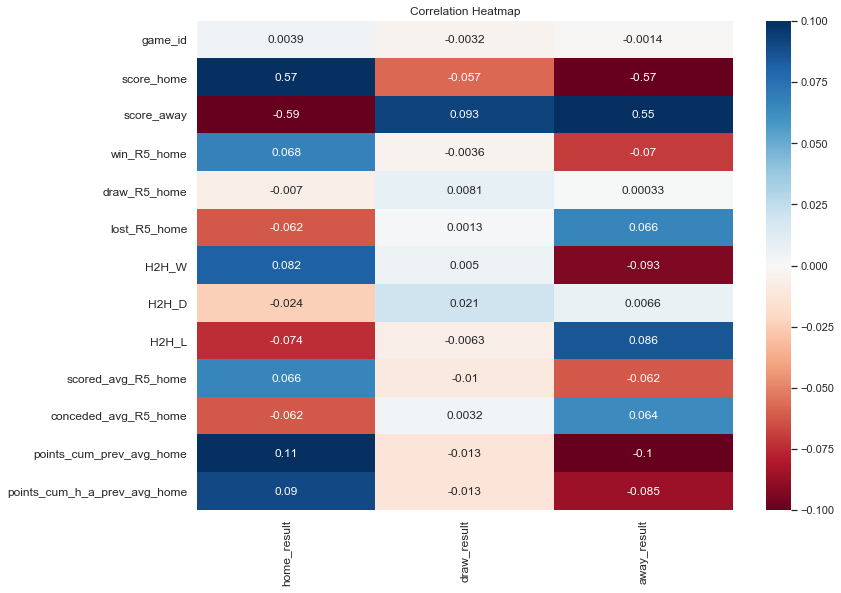

In [56]:
# Introduce binary outcome variables
df_games_trend['home_result'] = 0
df_games_trend.loc[(df_games_trend['result'] == 'home'), 'home_result'] = 1

df_games_trend['draw_result'] = 0
df_games_trend.loc[(df_games_trend['result'] == 'draw'), 'draw_result'] = 1

df_games_trend['away_result'] = 0
df_games_trend.loc[(df_games_trend['result'] == 'away'), 'away_result'] = 1

# Heatmap for correlations
plt.figure(figsize = (12, 9))
s = sns.heatmap(df_games_trend.corr()[['home_result', 'draw_result', 'away_result']][0:13],
               annot = True, 
               cmap = 'RdBu',
               vmin = -0.1, 
               vmax = 0.1)
s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize = 12)
plt.title('Correlation Heatmap')
plt.show()

Taking a closer look, the correlations looks as expected. For example, if the home team has high number of cumulative points, the probability of a win is higher. 
Some further points to notice is:

* Home win, correlation to the home team is higher than away team. For example the average points cumulative for home team has higher correlation then for the away team
* A draw has highest correlation to previous outcome between teams
* For away outcome, it is more important that the home team has a bad form than the away team having a good form. 

### 3. Prepare data for modeling

After the quick cleaning and exploration of the data, it's time to set up the machine learning model. 
There are some null values, coming from games in the beginning of the season where no trends can be calculated. 
The created columns for the correlation chart are also dropped. 

The data for current season is saved to another dataframe, as this will be used to evaluate the final performance of the model and thus should not be used when training the model.

In [57]:
df_model = df_games_trend[~df_games_trend.isnull().any(axis=1)].reset_index(drop=True)
df_model  = df_model.drop(['home_result','draw_result', 'away_result'], axis=1)

df_2019 = df_model[df_model['season']=='2019/20']
df_model = df_model[df_model['season']!='2019/20'].reset_index(drop=True)

print("Data current season: " + str(df_2019.shape[0]))
print("Data for modeling: " + str(df_model.shape[0]))


Data current season: 697
Data for modeling: 8107


Before moving on with the model, lets just check the distribution of the dependent variable. 

In [58]:
df_model['result'].value_counts(normalize=True)

home    0.472555
away    0.308869
draw    0.218577
Name: result, dtype: float64

It is important to note this distribution, as out dependent variable is imbalanced. A balanced dataset would give us about 1/3 per each home, away and draw outcome. Now we have a skewed distribution, and thus a baseline, primitive model only predicting "home" all the time would be right 50% of the times. This is important to keep in mind when evaluating the final outcome. The trained model should at least be better than this. 

This is a classification problem. Random forest is in general a popular algorithm to use. Random forest is kind of an advanced decision tree. The classifier from sklearn will be used. For this to work, the classes must be turned into factors. 

In [59]:
#Creating the dependent variable class
mapping = {'home': 0, 'draw': 1, 'away': 2}
df_model = df_model.replace({'result': mapping})

df_model.head()

,date,game,score,league,season,game_id,home,away,score_home,score_away,...,conceded_avg_R5_home,points_cum_prev_avg_home,points_cum_h_a_prev_avg_home,win_R5_away,draw_R5_away,lost_R5_away,scored_avg_R5_away,conceded_avg_R5_away,points_cum_prev_avg_away,points_cum_h_a_prev_avg_away
0,2018-09-20,Luleå HF - Örebro HK,2 - 3,shl,2018/19,393319,Luleå HF,Örebro HK,2,3,...,1.000000,3.000000,3.0,1.000000,0.000000,0.0,4.000000,2.000000,3.000000,3.0
1,2018-09-20,Linköping HC - HV 71,5 - 1,shl,2018/19,393326,Linköping HC,HV 71,5,1,...,1.000000,3.000000,3.0,0.000000,0.000000,1.0,1.000000,3.000000,0.000000,0.0
2,2018-09-22,Skellefteå AIK - Timrå IK,3 - 2,shl,2018/19,393341,Skellefteå AIK,Timrå IK,3,2,...,1.000000,2.500000,3.0,0.500000,0.000000,0.5,1.500000,2.500000,1.500000,0.0
3,2018-09-27,Luleå HF - Skellefteå AIK,3 - 5,shl,2018/19,393352,Luleå HF,Skellefteå AIK,3,5,...,3.000000,1.333333,2.0,0.333333,0.666667,0.0,3.333333,1.333333,2.333333,2.0
4,2018-09-27,Brynäs IF - Växjö Lakers HC,1 - 4,shl,2018/19,393354,Brynäs IF,Växjö Lakers HC,1,4,...,2.333333,1.333333,1.0,0.000000,0.500000,0.5,0.500000,1.500000,0.500000,0.0


### Identify dependent and independent variables

Time to split our data into independent and dependent variables. 

In [75]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8107 entries, 0 to 8106
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   date                          8107 non-null   object 
 1   game                          8107 non-null   object 
 2   score                         8107 non-null   object 
 3   league                        8107 non-null   object 
 4   season                        8107 non-null   object 
 5   game_id                       8107 non-null   int64  
 6   home                          8107 non-null   object 
 7   away                          8107 non-null   object 
 8   score_home                    8107 non-null   int64  
 9   score_away                    8107 non-null   int64  
 10  result                        8107 non-null   int64  
 11  win_R5_home                   8107 non-null   float64
 12  draw_R5_home                  8107 non-null   float64
 13  los

The dependent variable (what should be predicted) is in column 10, and the independent variables are in columns 11 to 27. 
A third variable with attributes are stored in the variable ```info```.

In [63]:
#Splitting the data into independent and dependent variables
X = df_model.iloc[:,11:].values
y = df_model.iloc[:,10].values
info = df_model.iloc[:,0:9].values

X_2019 = df_2019.iloc[:,11:].values
y_2019 = df_2019.iloc[:,10].values
info_2019 = df_2019.iloc[:,0:9].values


The data is split into train and test data, splitted 80/20.  
Considering our imbalanced data set, the input ``stratify =y`` is used in the function. 

In [64]:
# Random state = 21 (random number)
X_train, X_test, y_train, y_test, info_train, info_test  = train_test_split(X, y, info, 
                                                                            test_size = 0.2, stratify = y, random_state = 21)

Finally the independent variables has to be scaled as they are of different scales. This is done with the standard scaler in sklearn library. The mean value for each variable is subtracted and then divided by its unit variance  

In [65]:
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_2019 = scaler.transform(X_2019)

### 4. Train model

Data is ready to be used to train the model. 

In [88]:
# Fitting Random Forest Classification to the Training set
rf = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
rf.fit(X_train, y_train)

# save the model to disk
filename = "C:/Users/marcu/Documents/projects/icehockey/ml_models/rf_predict_game.sav"
pickle.dump(rf, open(filename, 'wb'))


### 5. Evaluate performance

Time to evaluate the performance of the model. 

In [89]:
y_pred_rf = rf.predict(X_test)
y_pred_rf_prob = rf.predict_proba(X_test)

print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.50      0.81      0.62       766
           1       0.27      0.03      0.06       355
           2       0.42      0.28      0.33       501

    accuracy                           0.48      1622
   macro avg       0.40      0.37      0.34      1622
weighted avg       0.42      0.48      0.41      1622



* Precision: Proportion of positive predictions that was correct?

* Recall: Proportion of actual positives that was identified

So, would it be possible to make any money out of this? 
* When we bet 1, we are right in 49% of the times
* Betting draw, we are right in 21% 
* When putting 2, the correct ratio is 33%



### Would using the model current season bring any money?

Now to the interesting part: Would the model bring any money?
We are testing the model on the data for 2019. 

In [90]:
y_pred2019_rf = rf.predict(X_2019)
y_pred2019_rf_prob = rf.predict_proba(X_2019)

df_2019 = pd.DataFrame(info_2019)

df_2019.columns = ['date', 'game', 'score', 'league', 'season', 'game_id', 'home', 'away','score_home']

# Set the outcome variables and probabilities
df_2019['actual'] = y_2019
df_2019['predicted'] = y_pred2019_rf
df_2019['prob_home'] = y_pred2019_rf_prob[:,0]
df_2019['prob_draw'] = y_pred2019_rf_prob[:,1]
df_2019['prob_away'] = y_pred2019_rf_prob[:,2]

# Map back sign outcome
mapping = {0:'home', 1:'draw', 2:'away'}
df_2019 = df_2019.replace({'actual': mapping, 'predicted': mapping})

df_2019['correct']=0
df_2019.loc[df_2019['actual']==df_2019['predicted'],'correct']=1

# Check mean values by sign
print("Correct ratio by prediction")
df_2019.groupby(['predicted'])['correct'].mean()

Correct ratio by prediction


predicted
away    0.398693
draw    0.416667
home    0.516917
Name: correct, dtype: float64

In [91]:
# Get odds data
df_odds = pd.read_csv("C:/Users/marcu/Documents/projects/icehockey/data/sweden_odds.csv", sep=',', decimal=',')

df_odds.head()

,Match,Resultat,date,score_home,score_away,played_1,played_X,played_2,odds_1,odds_X,odds_2,home,away,outcome,odds_outcome
0,Skelleft. - Grenoble,1 - 2,2019-09-01,1,2,81,13,6,1.13,8.50,12.70,Skellefteå AIK,Grenoble,2,12.70
1,Frölunda - HC Mountf,2 - 3,2019-09-01,2,3,76,16,8,1.34,5.70,6.25,Frölunda HC,HC Mountf,2,6.25
2,Vienna - Djurgård.,1 - 2,2019-09-01,1,2,24,24,52,4.40,5.45,1.49,Vienna,Djurgårdens IF,2,1.49
3,GKS Tychy - Mannheim,2 - 2,2019-09-01,2,2,11,14,75,10.50,7.60,1.17,GKS Tychy,Mannheim,X,7.60
4,Card Devi - EC Graz,3 - 3,2019-09-01,3,3,31,27,42,2.85,4.45,1.99,Card Devi,EC Graz,X,4.45


In [92]:
df_2019_odds = pd.merge(df_2019, df_odds[['date', 'home', 'away', 'odds_1', 'odds_X', 'odds_2', 'odds_outcome']],
                   on=['date', 'home', 'away'], how='left')

df_2019_odds.head()

,date,game,score,league,season,game_id,home,away,score_home,actual,predicted,prob_home,prob_draw,prob_away,correct,odds_1,odds_X,odds_2,odds_outcome
0,2019-09-19,Djurgårdens IF - Örebro HK,4 - 2,shl,2019/20,441818,Djurgårdens IF,Örebro HK,4,home,away,0.29,0.19,0.52,0,1.76,4.50,4.05,1.76
1,2019-09-19,Färjestad BK - Växjö Lakers HC,4 - 2,shl,2019/20,441819,Färjestad BK,Växjö Lakers HC,4,home,draw,0.20,0.44,0.36,0,2.06,4.15,3.20,2.06
2,2019-09-19,Frölunda HC - Linköping HC,4 - 0,shl,2019/20,441820,Frölunda HC,Linköping HC,4,home,draw,0.21,0.56,0.23,0,1.62,4.75,4.70,1.62
3,2019-09-19,Luleå HF - HV 71,3 - 2,shl,2019/20,441821,Luleå HF,HV 71,3,draw,home,0.46,0.20,0.34,0,1.82,4.20,4.00,4.20
4,2019-09-19,Rögle BK - IK Oskarshamn,0 - 1,shl,2019/20,441822,Rögle BK,IK Oskarshamn,0,away,home,0.51,0.18,0.31,0,1.53,5.10,5.25,5.25


In [93]:
df_2019_odds['return'] = df_2019_odds['odds_outcome']*df_2019_odds['correct']
df_2019_odds.loc[df_2019_odds['correct']==0,'return'] = -1

df_2019_odds.head()

,date,game,score,league,season,game_id,home,away,score_home,actual,predicted,prob_home,prob_draw,prob_away,correct,odds_1,odds_X,odds_2,odds_outcome,return
0,2019-09-19,Djurgårdens IF - Örebro HK,4 - 2,shl,2019/20,441818,Djurgårdens IF,Örebro HK,4,home,away,0.29,0.19,0.52,0,1.76,4.50,4.05,1.76,-1.0
1,2019-09-19,Färjestad BK - Växjö Lakers HC,4 - 2,shl,2019/20,441819,Färjestad BK,Växjö Lakers HC,4,home,draw,0.20,0.44,0.36,0,2.06,4.15,3.20,2.06,-1.0
2,2019-09-19,Frölunda HC - Linköping HC,4 - 0,shl,2019/20,441820,Frölunda HC,Linköping HC,4,home,draw,0.21,0.56,0.23,0,1.62,4.75,4.70,1.62,-1.0
3,2019-09-19,Luleå HF - HV 71,3 - 2,shl,2019/20,441821,Luleå HF,HV 71,3,draw,home,0.46,0.20,0.34,0,1.82,4.20,4.00,4.20,-1.0
4,2019-09-19,Rögle BK - IK Oskarshamn,0 - 1,shl,2019/20,441822,Rögle BK,IK Oskarshamn,0,away,home,0.51,0.18,0.31,0,1.53,5.10,5.25,5.25,-1.0


In [94]:
df_2019_odds.groupby(['predicted'])['return'].sum()

predicted
away     36.98
draw     14.20
home    235.88
Name: return, dtype: float64

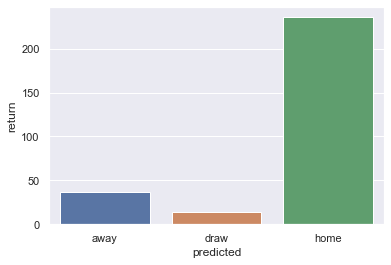

In [95]:
sns.barplot(x='predicted', y='return', 
            estimator = sum, data=df_2019_odds, ci=None)

In [96]:
df_2019_odds.to_csv("C:/Users/marcu/Documents/projects/icehockey/data/df_2019_odds.csv", index=False)